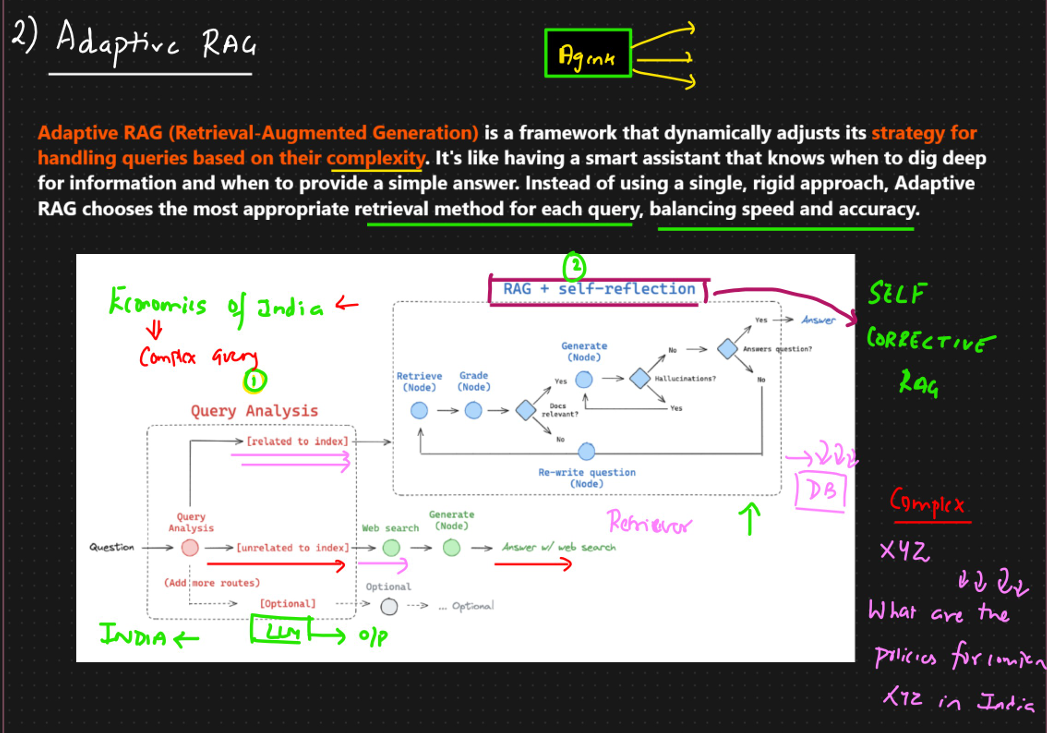

# 🔁 Adaptive RAG (Retrieval-Augmented Generation)

**Adaptive RAG** enhances traditional RAG by dynamically adjusting the retrieval process based on the query or system confidence.

---

## 🔍 Key Features

- 📌 Dynamically adjusts retrieval depth based on:
  - Query complexity
  - Confidence of retrieved info
  - Cost/latency constraints

- 🧠 Refines queries or fetches more documents if confidence is low

- 🛠 Uses rerankers or multiple retrieval rounds for better answers

---

## ✅ Benefits

| Benefit                | Description                                              |
|------------------------|----------------------------------------------------------|
| 🎯 Higher Accuracy     | Adapts to fetch better context per query                 |
| 🧱 Less Hallucination  | Improves grounding by verifying relevance                |
| 💰 Cost Efficient      | Fetches more only when needed                           |
| ⚡ Faster UX           | Handles easy queries quickly, spends time on harder ones |
| 🔄 Flexible & Scalable | Works across domains and tools                          |

---





# 🧠 LangGraph Workflow – Flow Explanation in Simple English

This workflow uses **adaptive retrieval-augmented generation** to intelligently answer user questions by deciding whether to search the web, retrieve from internal knowledge, or refine the query.

---

## 🔄 Step-by-Step Flow Explanation

### 1. 🚀 Start (`START`)
The flow begins by deciding how to handle the user's question using `route_question`.

### 2. 🧭 Routing the Question
- If the question needs live/current info → it routes to **`web_search`**
- If the answer exists in internal knowledge → it routes to **`retrieve`**

### 3. 🌐 Web Search Path
- `web_search` fetches data from the internet
- Then it goes directly to **`generate`** to produce an answer

### 4. 📚 Retrieval Path
- `retrieve` pulls documents from the vector store
- These are passed to **`grade_documents`** to check their quality

### 5. 🧪 Grade Documents
- If documents are good → go to **`generate`**
- If not good → go to **`transform_query`**

### 6. 🔁 Transform Query
- Refines or rephrases the question
- Then loops back to **`retrieve`** for better results

### 7. 📝 Generate Response
- `generate` creates the final response
- Then, a function (`grade_generation_v_documents_and_question`) checks if the answer is:
  - ✅ Useful → End the flow
  - 🔁 Not useful → Go back to `transform_query`
  - ❌ Not supported → Retry in `generate`

### 8. 🏁 End (`END`)
- Once a useful answer is generated, the workflow ends successfully

---


In [3]:
import os 
from dotenv import load_dotenv
load_dotenv()



True

In [5]:
from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="qwen/qwen3-32b")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content='<think>\nOkay, the user said "Hello". That\'s a greeting. I should respond in a friendly way. Maybe ask how they\'re doing. Keep it simple and open-ended to encourage them to talk more. Let me make sure there\'s no specific context I\'m missing here. Just a standard hello, so a standard warm response should work.\n</think>\n\nHello! How are you today? 😊', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 9, 'total_tokens': 91, 'completion_time': 0.192469459, 'prompt_time': 0.000370175, 'queue_time': 0.088680121, 'total_time': 0.192839634}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_f17c2eb555', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--81fcb46c-9a1a-41f7-8722-de1c54331db6-0', usage_metadata={'input_tokens': 9, 'output_tokens': 82, 'total_tokens': 91})

In [6]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter


In [7]:
### Build Index

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings

### from langchain_cohere import CohereEmbeddings

# 4. Embed and Save to FAISS
# Load your API key from the .env file
load_dotenv()
GOOGLE_API_KEY = os.getenv("Google_API_KEY")
# ========================
embd = GoogleGenerativeAIEmbeddings(model="models/embedding-001", google_api_key=GOOGLE_API_KEY)


# Docs to index
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorstore
vectorstore=FAISS.from_documents(
    documents=doc_splits,
    embedding=embd
)


retriever=vectorstore.as_retriever()

In [8]:
retriever.invoke("What is an agent?")

[Document(id='0559e8bb-ef78-4f67-aed0-941ce996aa91', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, 

In [10]:
# Making a router it go to web search or  vectorstore retriever
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field

# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "web_search"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    )

llm = ChatGroq(model="qwen/qwen3-32b")
structured_llm_question=llm.with_structured_output(RouteQuery)

system="""You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use web-search"""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)
# LLM with function call
llm = ChatGroq(model="qwen/qwen3-32b")
structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt
system = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use web-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router

print(
    question_router.invoke(
        {"question": "Who won the Cricket world cup 2023 "}
    )
)


datasource='web_search'


In [12]:
## Grade documenr node
# Retriver document  
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from pydantic import BaseModel, Field

class Grader(BaseModel):
    "binary classification of the document it give yes if relevant of document and no if not relevant"
    binary_score: str = Field(description="binary score of the document, yes or no")



llm = ChatGroq(model="qwen/qwen3-32b")
structured_llm_grader=llm.with_structured_output(Grader)



# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

##chain the prompt with the LLM
retrieval_grader = grade_prompt | structured_llm_grader
question = "agent memory"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))


binary_score='yes'


In [14]:
## Generate a response
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

prompt =hub.pull("rlm/rag-prompt")

llm = ChatGroq(model="qwen/qwen3-32b")


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

<think>
Okay, the user is asking about "agent memory" in the context of LLM-powered autonomous agents. Let me look through the provided documents to find relevant information.

First, in the documents, there's a section titled "Component Two: Memory" which discusses different types of memory. It mentions short-term memory as in-context learning, which is limited by the model's context window. Then there's long-term memory, which uses an external vector store for infinite information retention and fast retrieval. They also talk about sensory memory, which is like the initial processing of inputs.

Another part of the document explains that short-term memory in agents is similar to working memory, handling current tasks, while long-term memory involves external storage for persistent data. The comparison to human memory types (sensory, short-term, long-term) is made, mapping them to different aspects of the agent's architecture.

The user wants a concise answer, so I should focus on the 

In [16]:
### Hallucination Grader


# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatGroq(model="qwen/qwen3-32b")
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='yes')

In [18]:
### Answer Grader


# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# LLM with function call

llm = ChatGroq(model="qwen/qwen3-32b")
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question, "generation": generation})

GradeAnswer(binary_score='yes')

In [19]:
# if the Answer Grader are return the no it use th ere writer to better making the question to give answer form vectorstore retriever
llm = ChatGroq(model="qwen/qwen3-32b")

system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""



re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'<think>\nOkay, the user provided the initial question "agent memory" and wants an improved version for vectorstore retrieval. Let me start by understanding what they\'re asking for.\n\nVectorstore retrieval usually relies on clear, specific, and context-rich queries. The original question is very broad. "Agent memory" could refer to various things like memory mechanisms in AI agents, how agents store information, or specific models/techniques related to memory in agents.\n\nI need to figure out the user\'s intent. They might be looking for information on how agent memory systems are implemented, their architecture, or perhaps best practices for managing memory in AI agents. Since the original question is vague, the improved version should add context or specify a particular aspect.\n\nPossible directions: "What is agent memory in AI systems?" or "How do AI agents utilize memory mechanisms?" Maybe they\'re interested in technical details, like "What are the key components of an agent\'

In [20]:
# websearch
tavily_key = os.getenv("TAVILY_API_KEY")
if tavily_key is None:
    print("Error: TAVILY_API_KEY not found in environment variables")
else:
    os.environ["TAVILY_API_KEY"] = tavily_key


from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

C:\Users\User\AppData\Local\Temp\ipykernel_5488\2724188780.py:11: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  web_search_tool = TavilySearchResults(k=3)


In [21]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

In [23]:
from langchain.schema import Document

def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

def generate(state):
    """
    Generate an answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains the LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # Generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": web_results, "question": question}



In [24]:
### Edges ###


def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

In [25]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("web_search", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile()

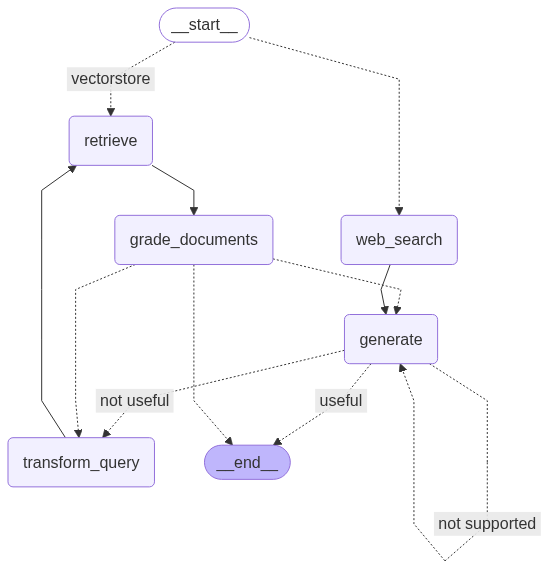

In [26]:
app

In [27]:
app.invoke({"question":"What is machine learning"})

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---


{'question': 'What is machine learning',
 'generation': '<think>\nOkay, the user is asking, "What is machine learning?" Let me look through the provided context to find the answer.\n\nFirst, the context says machine learning is a subfield of artificial intelligence. It mentions that it allows computers to learn without explicit programming, as defined by Arthur Samuel in the 1950s. There\'s also info about it using algorithms trained on data to make predictions and classifications. The context differentiates it from AI by stating that ML is a specific type of AI focused on learning from data. It also talks about applications like product recommendations and stock predictions. I need to condense this into a concise answer, making sure to highlight that ML is part of AI, uses data to learn, and doesn\'t require explicit programming. Let me check if there\'s any conflicting info. No, all the key points align. I should mention it\'s a subfield of AI, the learning without explicit programmi

In [28]:
app.invoke({"question":"What is agentic ai"})

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---


{'question': 'What is agentic ai',
 'generation': '<think>\nOkay, I need to answer the question "What is agentic AI?" using the provided context. Let me start by reviewing the context given. The documents mention that agentic AI refers to autonomous agents powered by large language models (LLMs). These agents are designed to handle complex tasks by breaking them down into subgoals, using both short-term and long-term memory, and interacting with external tools via APIs.\n\nThe context also highlights examples like AutoGPT, GPT-Engineer, and BabyAGI as proof-of-concept demonstrations. The system overview explains that the LLM acts as the core controller, complemented by components like planning, memory, and tool use. Planning involves decomposition and reflection, memory includes short-term (in-context learning) and long-term (external storage), and tool use allows the agent to access external information and execute code.\n\nI should ensure the answer covers the key components: LLM as 

In [29]:
app.invoke({"question":"What is prompting and how to use it in agentic ai?"})

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---


{'question': 'What is prompting and how to use it in agentic ai?',
 'generation': '<think>\nOkay, the user is asking about prompting and how to use it in agentic AI. Let me start by recalling what the context says.\n\nFrom the documents, prompt engineering is about steering the behavior of large language models (LLMs) through specific input designs without changing the model weights. It\'s an empirical approach that varies by model and requires experimentation. Techniques mentioned include zero-shot, few-shot, chain-of-thought (CoT), self-consistency sampling, and methods like Automatic Prompt Engineer (APE). \n\nSince the user mentioned "agentic AI," I should link these techniques to how they can guide an autonomous agent\'s decision-making. Agentic AI likely involves the model acting as an agent, making decisions or solving problems step-by-step. Techniques like CoT would help structure the agent\'s reasoning, while few-shot examples provide it with problem-solving blueprints. Also, 